In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from astropy import units as u
from astropy.constants import c
import datetime
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, CartesianDifferential, solar_system_ephemeris, get_body_barycentric
from astropy.time import Time

In [31]:
pathtemplate = "data" #put the filepath to the data here

In [32]:
#class to hold solar transit data - initially implemented by Joe and edited by me
class Transit:
    def __init__(self, date, dec, horn, noon):
        self.date = date #date is the filename of the solar scan data
        self.dec = dec #dec at solar noon (get from noaa solar calculator)
        self.horn = horn #E or W
        self.noon = noon #solar noon time (get from noaa solar calculator)
    def get_data(self):
        folder = os.path.join(pathtemplate, f"{self.date}")
        datetimes = np.load(os.path.join(folder, 'datetimes.npy'), allow_pickle=True)
        a1p1 = np.load(os.path.join(folder, 'a1p1_bandpass.npy'), allow_pickle=True)
        a1p2 = np.load(os.path.join(folder, 'a1p2_bandpass.npy'), allow_pickle=True)
        a2p1 = np.load(os.path.join(folder, 'a2p1_bandpass.npy'), allow_pickle=True)
        a2p2 = np.load(os.path.join(folder, 'a2p2_bandpass.npy'), allow_pickle=True)
        power_array = np.stack((a2p1, a1p2, a1p1, a2p2))

        #a1p1, a2p2 = WEST, a1p2, a2p1 = EAST

        return datetimes, power_array

In [33]:
#function to compare an L-BASS hydrogen profile with data from the LAB survey with a given LSR correction
#transit is the Transit object containing the hydrogen profile
#time is the time of the hydrogen profile from the start of the transit in minutes
#lab is the LAB data for the desired hydrogen profile (downloaded from https://www.astro.uni-bonn.de/hisurvey/euhou/LABprofile/index.php)
#lsr_corr is the LSR correction to apply to the velocity of the hydrogen profile in km/s
#start and end are the frequency channels to interpolate over for bandpass subtraction (ie the hydrogen profile lies between these channels)
def profile(transit, time, lab, lsr_corr, start, end):

    t, pwr = transit.get_data()

    pwr_trim = pwr[:,time-1:time+1,:] * 10.65 #selecting the data for one minute either side of the hydrogen profile
    pwr_trim[0, :,np.argmax(pwr_trim[0,:,:])-3:np.argmax(pwr_trim[0,:,:])+3] = 1 #removing the CW signal so that the bandpass plot is readable
    
    freq = np.linspace(1400, 1425, 457) #generating frequency array

    #interpolating over the hydrogen signal (across channels start-end) and subtracting the bandpass
    profile_bandpass = np.empty(718)
    for i in range(0,718):
        profile_bandpass[i] = np.sum(pwr_trim[0][:,i])
    bandpass = np.concatenate((profile_bandpass[:start], np.linspace(0,0,end-start), profile_bandpass[end:]))
    zero_indices = np.where(bandpass == 0)[0]
    non_zero_indices = np.where(bandpass != 0)[0]
    bandpass[zero_indices] = np.interp(zero_indices, non_zero_indices, bandpass[non_zero_indices])
    profile = (profile_bandpass-bandpass)[112:569]

    plt.figure(figsize=(10, 5))
    plt.plot(freq, profile_bandpass[112:569], marker=".", color='b', label="L-BASS Signal")
    plt.plot(freq, bandpass[112:569], color='r', label="Baseline")
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Brightness Temperature [K]')
    plt.grid(True)
    plt.legend()
    plt.show()

    hydrogen_line = 1420.405751786 #hydrogen line frequency in MHz
    vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + lsr_corr*(u.km/u.s) #converting frequency to velocity with LSR correction
    
    #rebinning LAB data to match L-BASS data
    lab_vel = lab[:,0]
    lab_pwr = lab[:,1] / np.max(lab[:,1])
    lab_rebinned = np.empty(len(vel))
    width = ((vel[1]-vel[0])/2).value
    for i in range(len(vel)):
        rhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value-width))[0])
        lhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value+width))[0])
        lab_rebinned[i] = np.sum(lab_pwr[lhs-1:rhs])

    #plotting the L-BASS and LAB data (step plot)
    plt.figure(figsize=(20, 10))
    plt.step(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.step(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.step(vel,profile/np.max(profile), marker=".", color='b', label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    #plotting the L-BASS and LAB data (line plot)
    plt.figure(figsize=(20, 10))
    plt.plot(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.plot(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.plot(vel,profile/np.max(profile), color='b', marker=".", label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    #calculating and plotting the residuals between the L-BASS and LAB data
    residuals = -(profile/np.max(profile)-lab_rebinned/np.max(lab_rebinned))
    plt.figure(figsize=(20, 10))
    plt.plot(vel, residuals, marker=".", color='g', label="Residuals")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile Residuals")
    plt.xlim(-150,50)
    plt.show()

    #calculating the integrated area under the LAB and L-BASS profiles
    lab_int = np.abs(np.sum(lab_rebinned/np.max(lab_rebinned) * np.diff(vel)[0]))
    lb_int = np.abs(np.sum(profile/np.max(profile) * np.diff(vel)[0]))

    print("Area under LAB profile: ", "{0:.3}".format(lab_int.value))
    print("Area under L-BASS profile: ", "{0:.3}".format(lb_int.value))
    print("Difference as a % of L-BASS profile: ", "{0:.3}".format(100*np.abs((lb_int-lab_int)/lb_int).value), "%")

In [34]:
#function to compare an L-BASS hydrogen profile with data from the LAB survey, finding the best-fit "empirical" LSR correction
#transit is the Transit object containing the hydrogen profile
#time is the time of the hydrogen profile from the start of the transit in minutes
#lab is the LAB data for the desired hydrogen profile (downloaded from https://www.astro.uni-bonn.de/hisurvey/euhou/LABprofile/index.php)
#start and end are the frequency channels to interpolate over for bandpass subtraction (ie the hydrogen profile lies between these channels)
def profile_empirical_vel(transit, time, lab, start, end):

    t, pwr = transit.get_data()

    pwr_trim = pwr[:,time-1:time+1,:] * 10.65 #selecting the data for one minute either side of the hydrogen profile
    pwr_trim[0, :,np.argmax(pwr_trim[0,:,:])-3:np.argmax(pwr_trim[0,:,:])+3] = 1 #removing the CW signal so that the bandpass plot is readable

    freq = np.linspace(1400, 1425, 457) #generating frequency array

    #interpolating over the hydrogen signal (across channels start-end) and subtracting the bandpass
    profile_bandpass = np.empty(718)
    for i in range(0,718):
        profile_bandpass[i] = np.sum(pwr_trim[0][:,i])
    bandpass = np.concatenate((profile_bandpass[:start], np.linspace(0,0,end-start), profile_bandpass[end:]))
    zero_indices = np.where(bandpass == 0)[0]
    non_zero_indices = np.where(bandpass != 0)[0]
    bandpass[zero_indices] = np.interp(zero_indices, non_zero_indices, bandpass[non_zero_indices])
    profile = (profile_bandpass-bandpass)[112:569]

    plt.figure(figsize=(10, 5))
    plt.plot(freq, profile_bandpass[112:569], marker=".", color='b', label="L-BASS Signal")
    plt.plot(freq, bandpass[112:569], color='r', label="Baseline")
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('Brightness Temperature [K]')
    plt.grid(True)
    plt.legend()
    plt.show()

    hydrogen_line = 1420.405751786 #hydrogen line frequency in MHz
    lsr_corr = np.linspace(-25,25,10000)*u.km/u.s #LSR correction array to search over
    residuals = np.empty(10000) #array to store residuals

    #rebin LAB data to match L-BASS data and search for the best-fit LSR correction that minimises the residuals
    lab_vel = lab[:,0]
    lab_pwr = lab[:,1] / np.max(lab[:,1])
    for i in range(10000):
        vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + lsr_corr[i]

        lab_rebinned = np.empty(len(vel))
        width = ((vel[1]-vel[0])/2).value

        for j in range(len(vel)):
            rhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[j].value-width))[0])
            lhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[j].value+width))[0])
            lab_rebinned[j] = np.sum(lab_pwr[lhs-1:rhs])

        residuals[i] = np.average(np.abs(-(profile/np.max(profile)-lab_rebinned/np.max(lab_rebinned))))

    print("Empirical LSR correction found to be: ", lsr_corr[np.argmin(residuals)], "km/s.")

    #rebinning LAB data to match L-BASS data with the best-fit LSR correction
    vel = -(freq-hydrogen_line)/hydrogen_line*c.to(u.km/u.s) + lsr_corr[np.argmin(residuals)]
    lab_rebinned = np.empty(len(vel))
    width = ((vel[1]-vel[0])/2).value
    for i in range(len(vel)):
        rhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value-width))[0])
        lhs = int(np.where(lab_vel == find_nearest(lab_vel, vel[i].value+width))[0])
        lab_rebinned[i] = np.sum(lab_pwr[lhs-1:rhs])

    #plotting the L-BASS and LAB data (step plot)
    plt.figure(figsize=(20, 10))
    plt.step(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.step(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.step(vel,profile/np.max(profile), marker=".", color='b', label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    #plotting the L-BASS and LAB data (line plot)
    plt.figure(figsize=(20, 10))
    plt.plot(lab_vel, lab_pwr, marker=".", color='r', label="LAB")
    plt.plot(vel, lab_rebinned/np.max(lab_rebinned), marker=".", color='m', label="LAB (re-binned)")
    plt.plot(vel,profile/np.max(profile), color='b', marker=".", label="L-BASS")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile")
    plt.xlim(-150,50)
    plt.show()

    #calculating and plotting the residuals between the L-BASS and LAB data
    residuals = -(profile/np.max(profile)-lab_rebinned/np.max(lab_rebinned))
    plt.figure(figsize=(20, 10))
    plt.plot(vel, residuals, marker=".", color='g', label="Residuals")
    plt.xlabel('Radial Velocity [km/s]')
    plt.ylabel('Normalised Power')
    plt.grid(True)
    plt.legend()
    plt.title("HI Profile Residuals")
    plt.xlim(-150,50)
    plt.show()
    
    #calculating the integrated area under the LAB and L-BASS profiles
    lab_int = np.abs(np.sum(lab_rebinned/np.max(lab_rebinned) * np.diff(vel)[0]))
    lb_int = np.abs(np.sum(profile/np.max(profile) * np.diff(vel)[0]))

    print("Area under LAB profile: ", "{0:.3}".format(lab_int.value))
    print("Area under L-BASS profile: ", "{0:.3}".format(lb_int.value))
    print("Difference as a % of L-BASS profile: ", "{0:.3}".format(100*np.abs((lb_int-lab_int)/lb_int).value), "%")

In [35]:
#function to find the nearest value in an array to a given value, used to rebin LAB data for comparison with L-BASS hydrogen profiles
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [44]:
ra0 = np.genfromtxt("data/hydrogen profiles/dec42/ra0dec42.txt", skip_header=4)
ra2 = np.genfromtxt("data/hydrogen profiles/dec42/ra2dec42.txt", skip_header=4)
ra4 = np.genfromtxt("data/hydrogen profiles/dec42/ra4dec42.txt", skip_header=4)
ra6 = np.genfromtxt("data/hydrogen profiles/dec42/ra6dec42.txt", skip_header=4)
ra8 = np.genfromtxt("data/hydrogen profiles/dec42/ra8dec42.txt", skip_header=4)
ra10 = np.genfromtxt("data/hydrogen profiles/dec42/ra10dec42.txt", skip_header=4)
ra12 = np.genfromtxt("data/hydrogen profiles/dec42/ra12dec42.txt", skip_header=4)
ra14 = np.genfromtxt("data/hydrogen profiles/dec42/ra14dec42.txt", skip_header=4)
ra16 = np.genfromtxt("data/hydrogen profiles/dec42/ra16dec42.txt", skip_header=4)
ra18 = np.genfromtxt("data/hydrogen profiles/dec42/ra18dec42.txt", skip_header=4)
ra20 = np.genfromtxt("data/hydrogen profiles/dec42/ra20dec42.txt", skip_header=4)
ra22 = np.genfromtxt("data/hydrogen profiles/dec42/ra22dec42.txt", skip_header=4)

ra = [ra0, ra2, ra4, ra6, ra8, ra10, ra12, ra14, ra16, ra18, ra20, ra22]

In [37]:
transit = Transit("16th Aug 2024 - 19th - DEC STRIP", 42, "W", datetime.datetime(2024, 8, 16, 15, 1, 39))

In [62]:
t, pwr = transit.get_data()
print(t[685])

2024-08-17 02:26:39.061509


In [64]:
obstime = Time('2024-08-17T14:26:39', scale='utc')
jodrell_bank = EarthLocation(lat=53.234329 * u.deg, lon=-2.3050403 * u.deg, height=77 * u.m)
altaz = AltAz(location=jodrell_bank, obstime=obstime)
point = SkyCoord('12h0m0s', '42deg', location=jodrell_bank, obstime=obstime)
print(point.transform_to(altaz))

<SkyCoord (AltAz: obstime=2024-08-17T14:26:39.000, location=(3822771.21279654, -153875.18467088, 5086256.75673384) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (181.90736283, 78.62712044)>


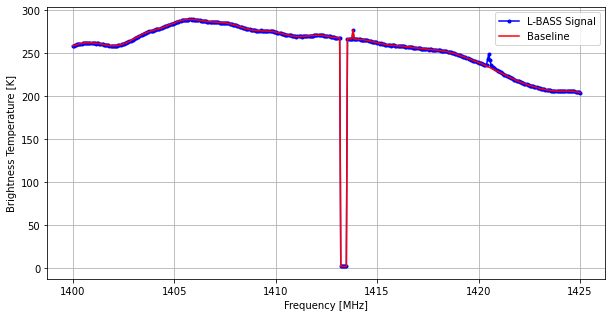

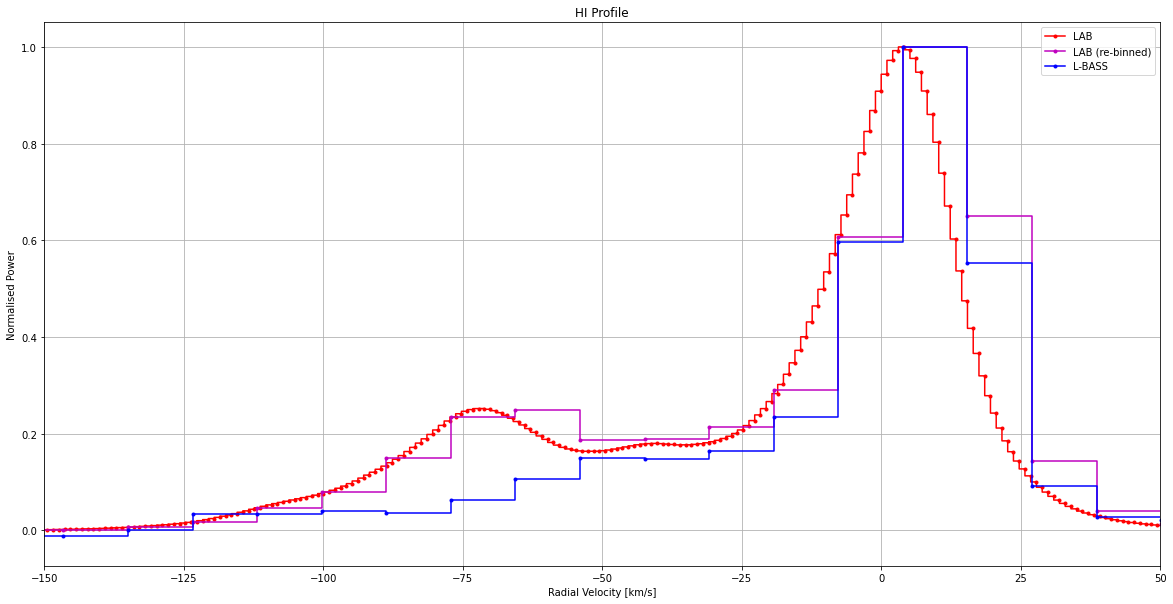

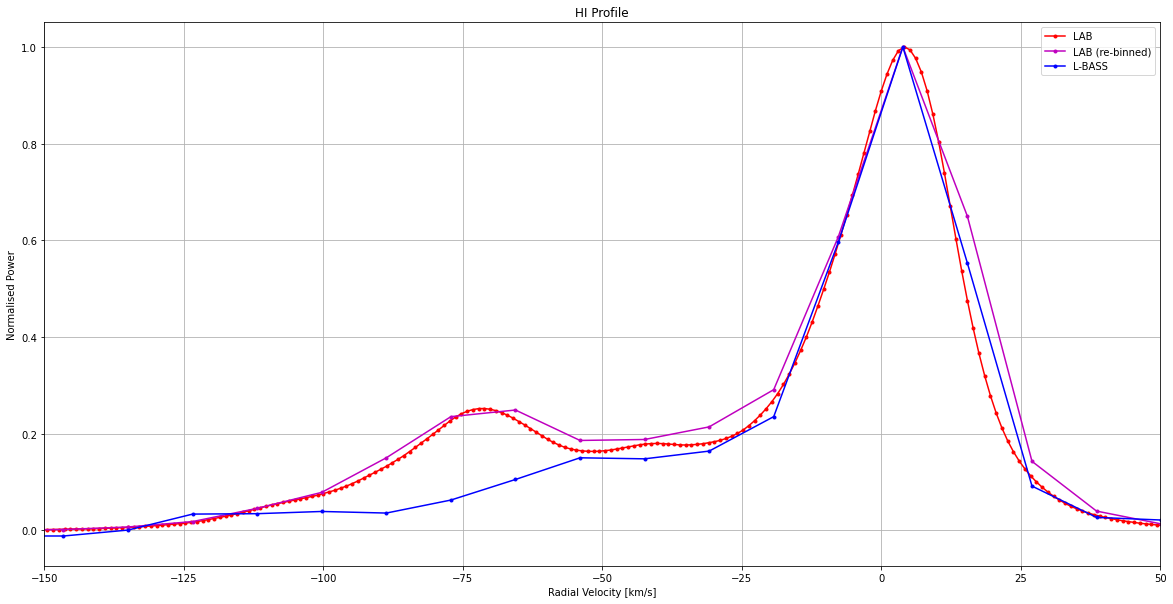

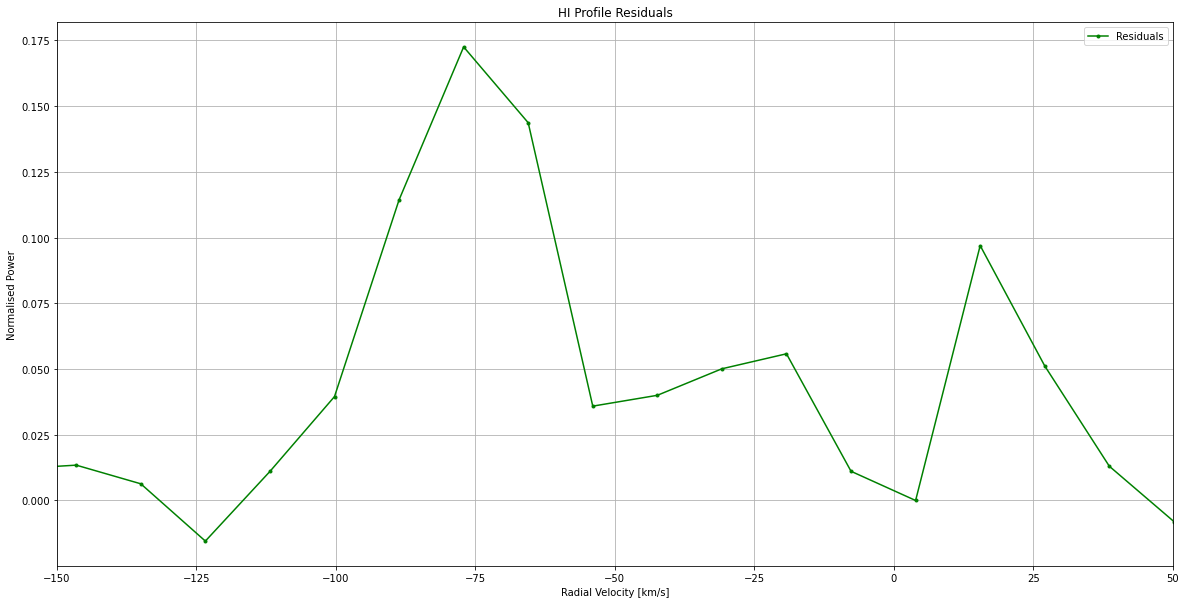

Area under LAB profile:  47.9
Area under L-BASS profile:  37.6
Difference as a % of L-BASS profile:  27.6 %


In [66]:
profile(transit, 685+(10*120), ra[10], 24.7, 480, 501)

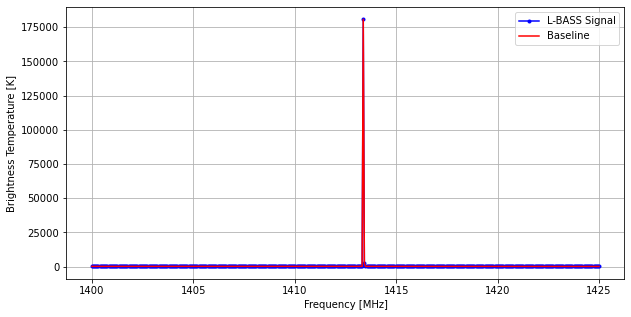

Empirical LSR correction found to be:  18.019301930193024 km / s km/s.


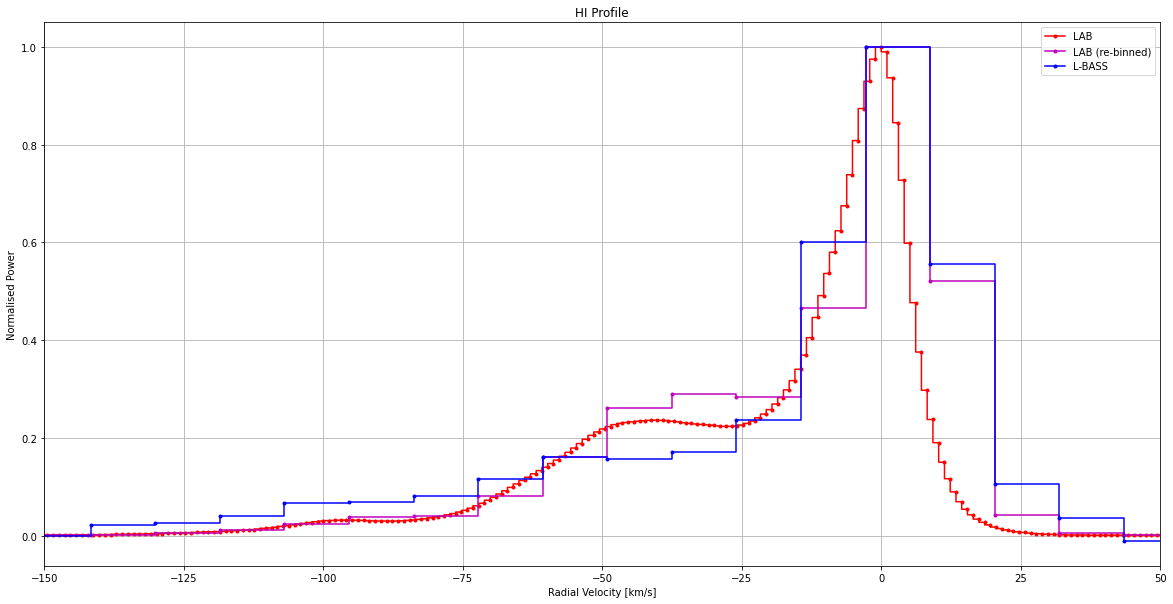

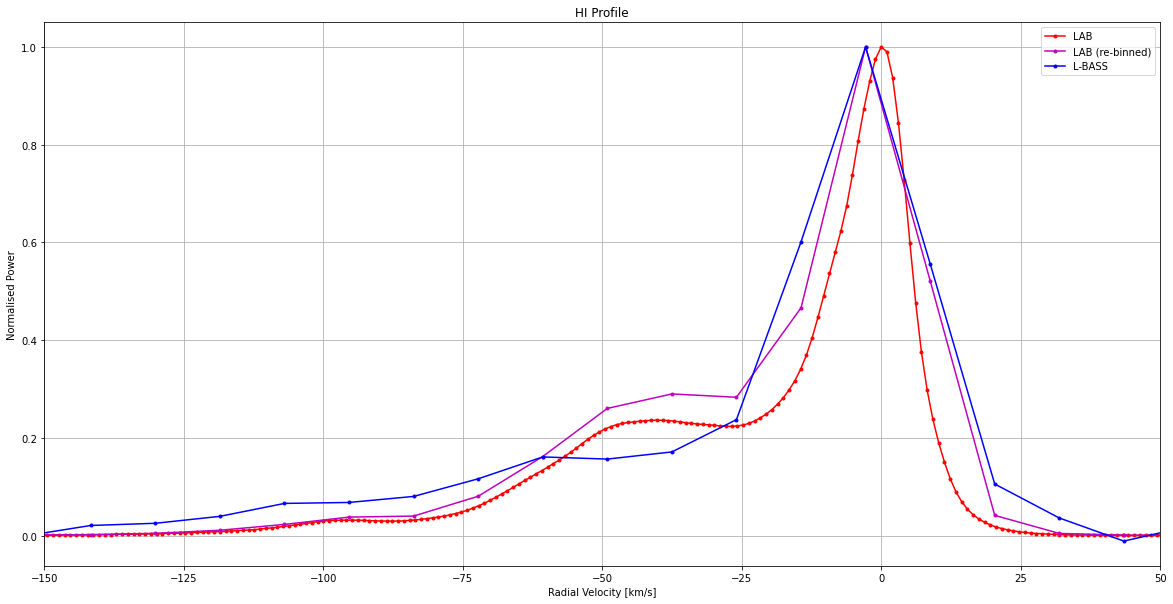

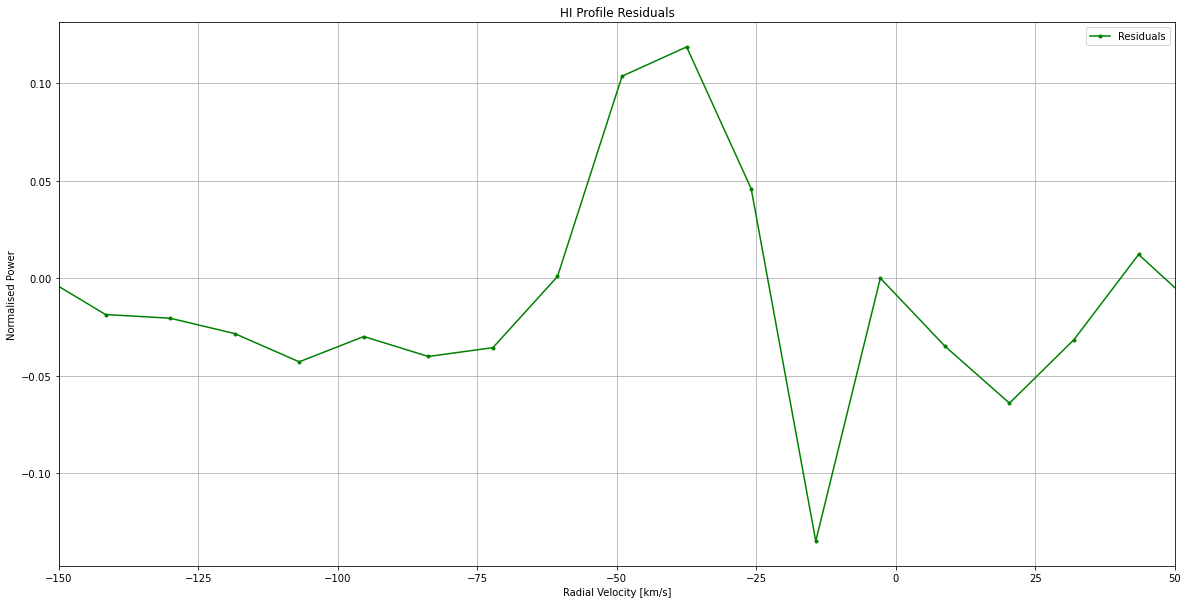

Area under LAB profile:  37.8
Area under L-BASS profile:  39.9
Difference as a % of L-BASS profile:  5.33 %


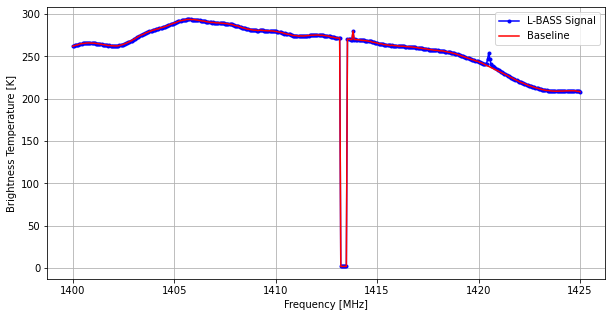

Empirical LSR correction found to be:  16.969196919691974 km / s km/s.


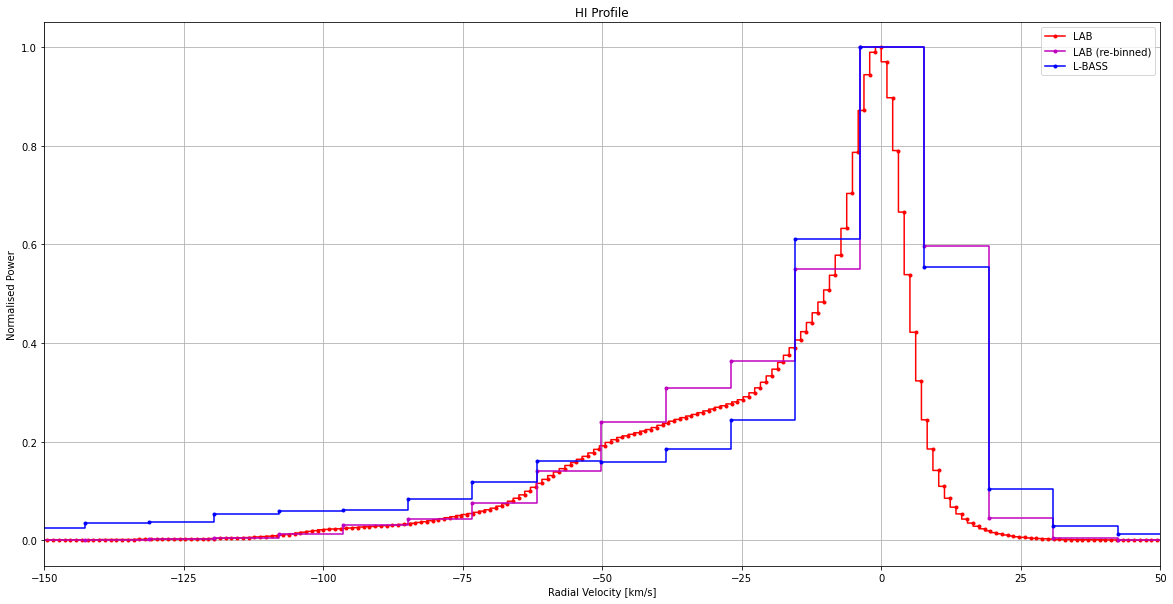

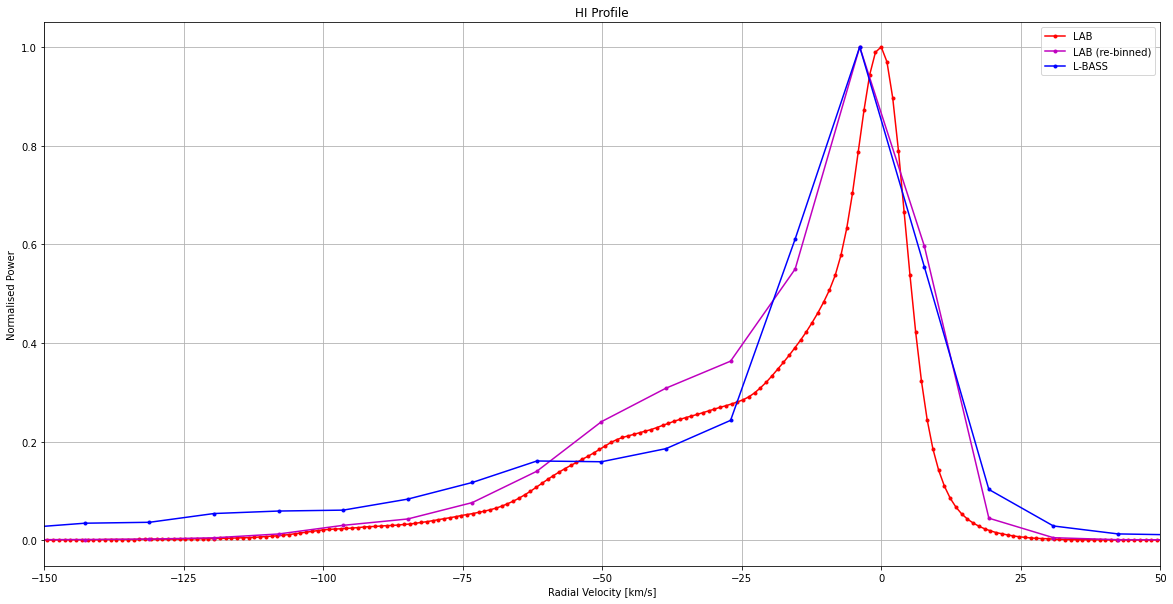

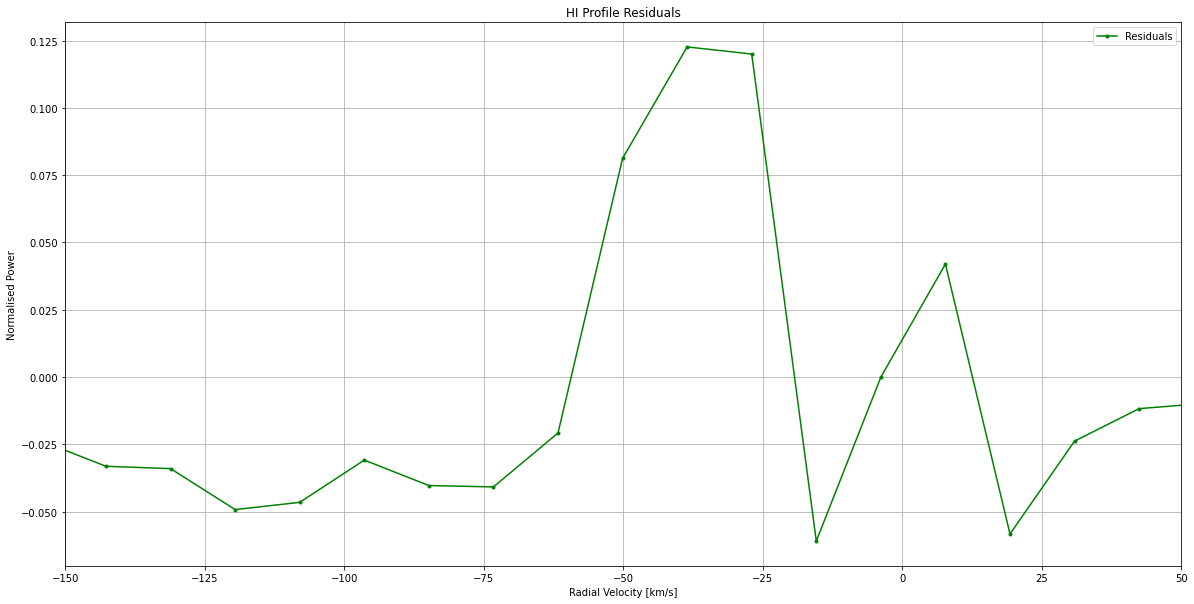

Area under LAB profile:  40.0
Area under L-BASS profile:  41.1
Difference as a % of L-BASS profile:  2.78 %


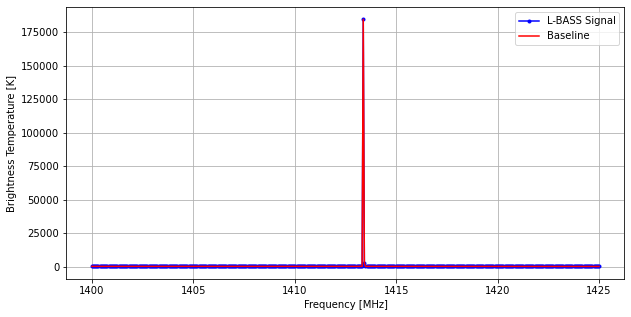

Empirical LSR correction found to be:  17.819281928192822 km / s km/s.


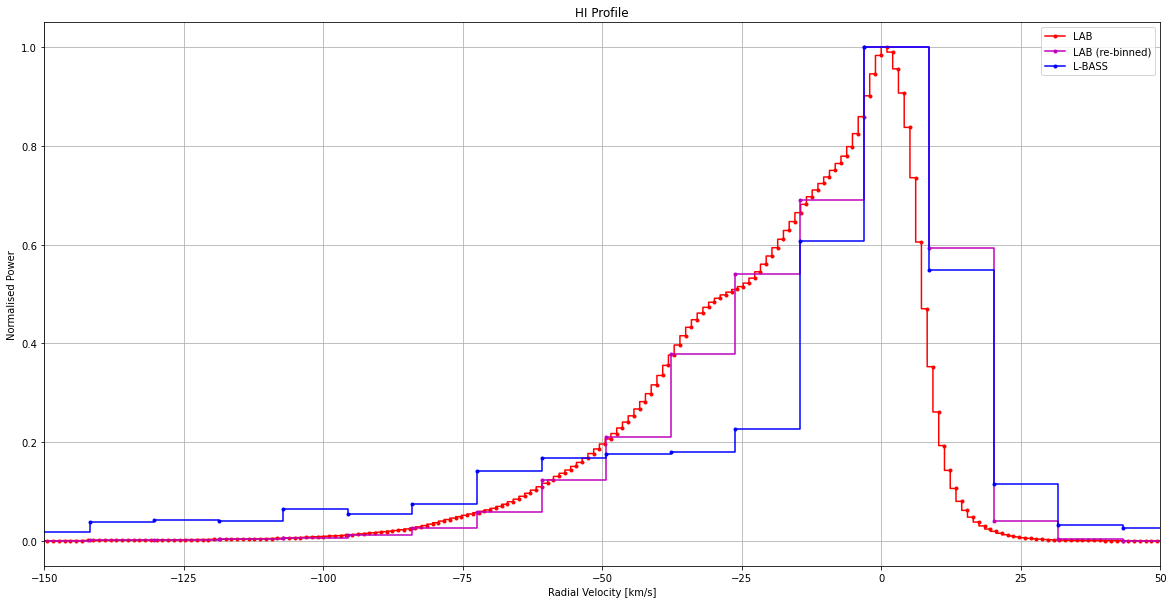

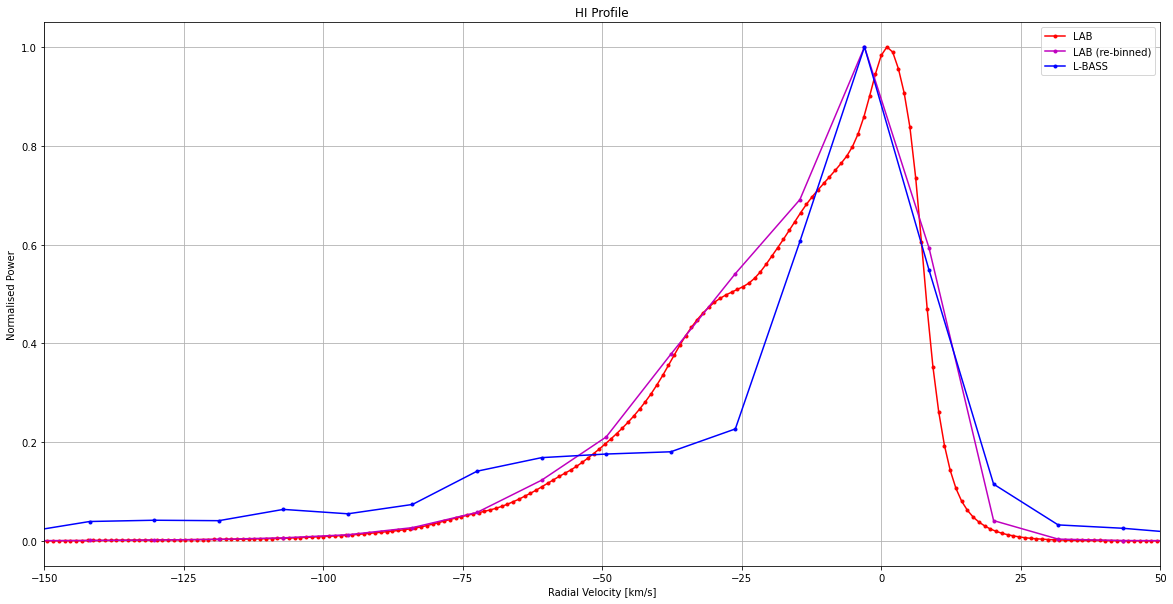

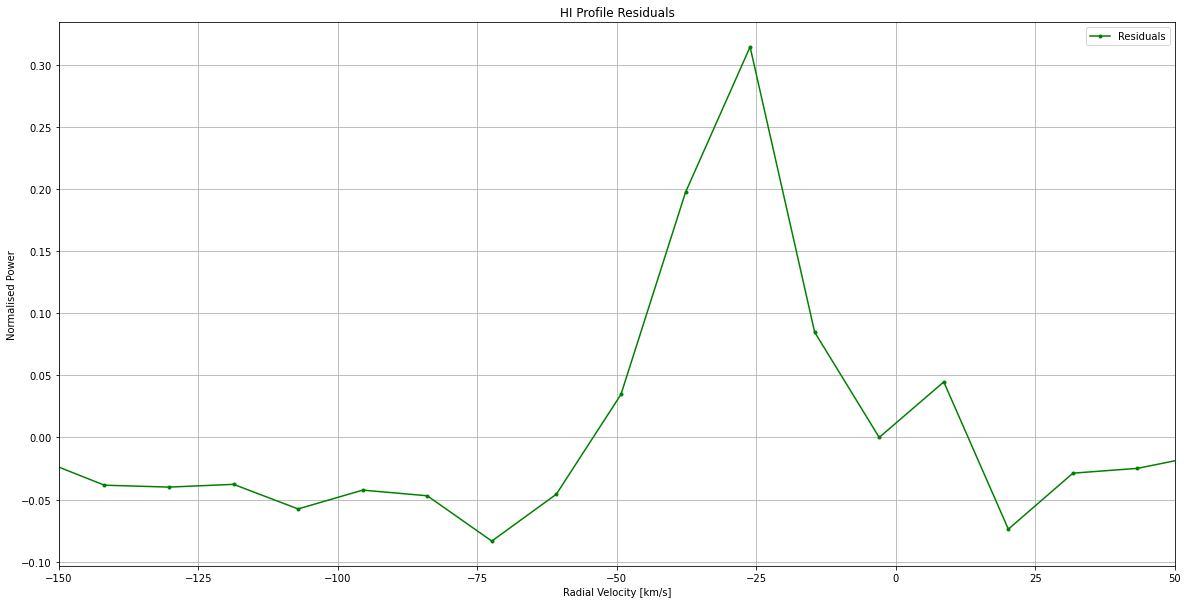

Area under LAB profile:  42.9
Area under L-BASS profile:  41.5
Difference as a % of L-BASS profile:  3.39 %


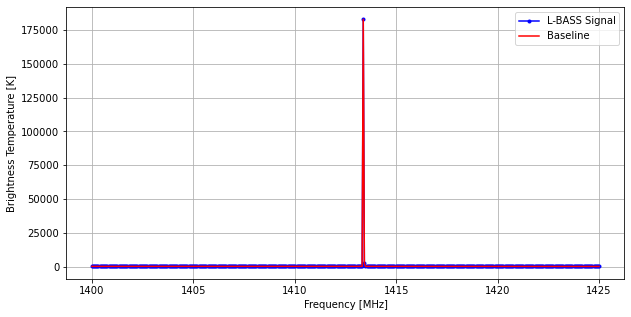

Empirical LSR correction found to be:  17.789278927892788 km / s km/s.


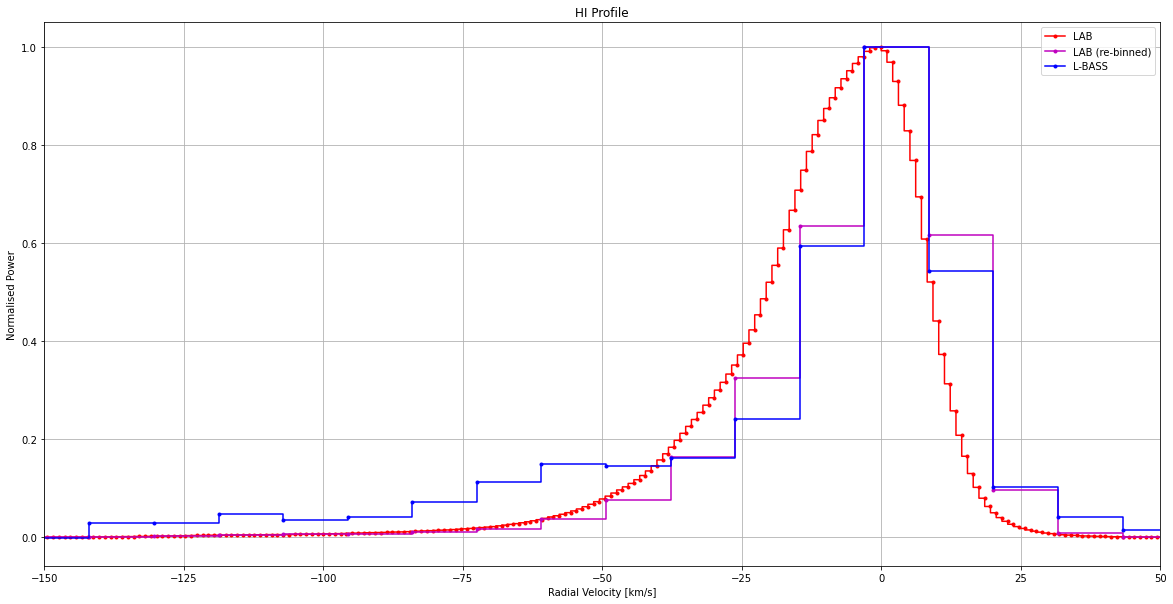

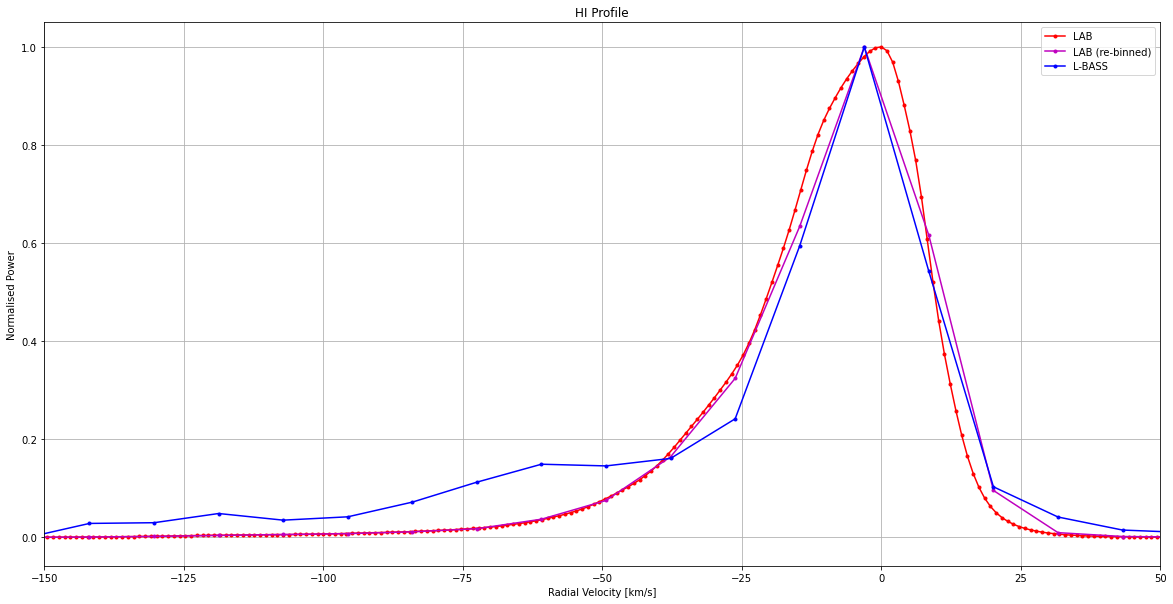

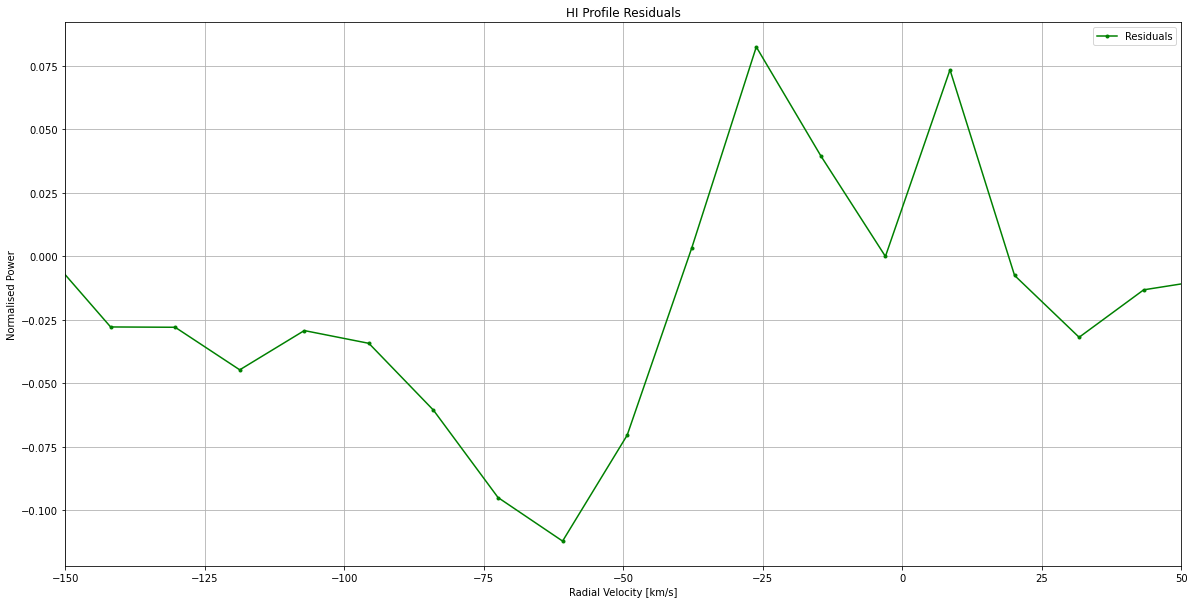

Area under LAB profile:  35.0
Area under L-BASS profile:  38.9
Difference as a % of L-BASS profile:  10.1 %


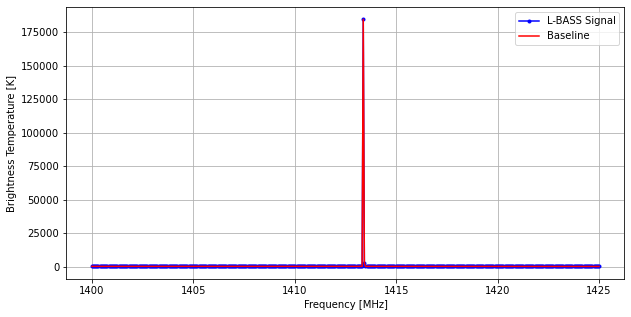

Empirical LSR correction found to be:  22.904790479047904 km / s km/s.


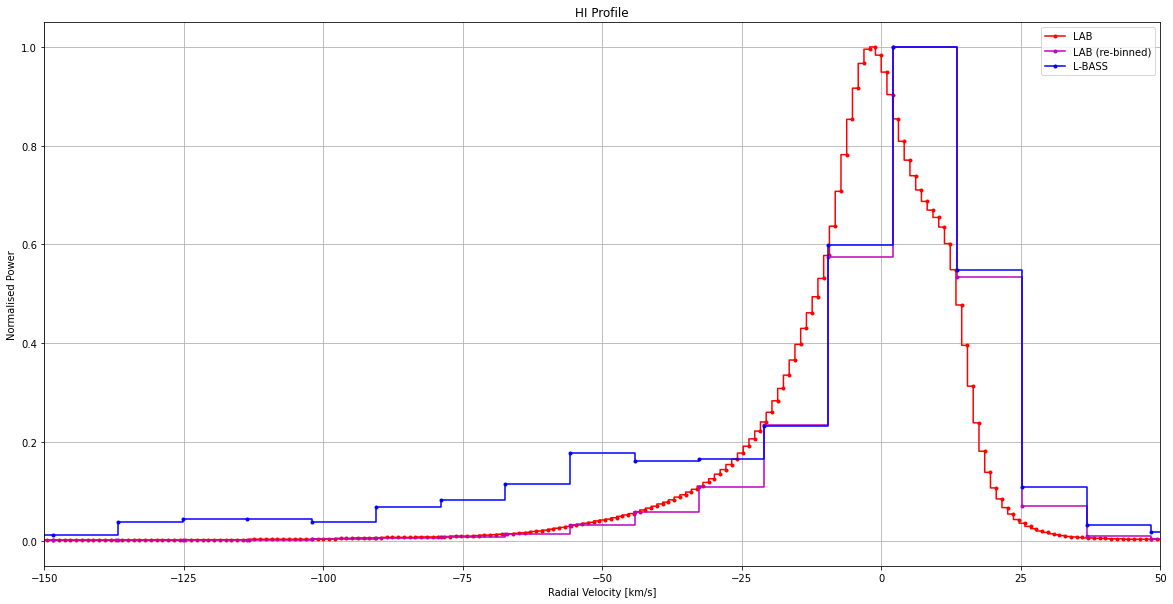

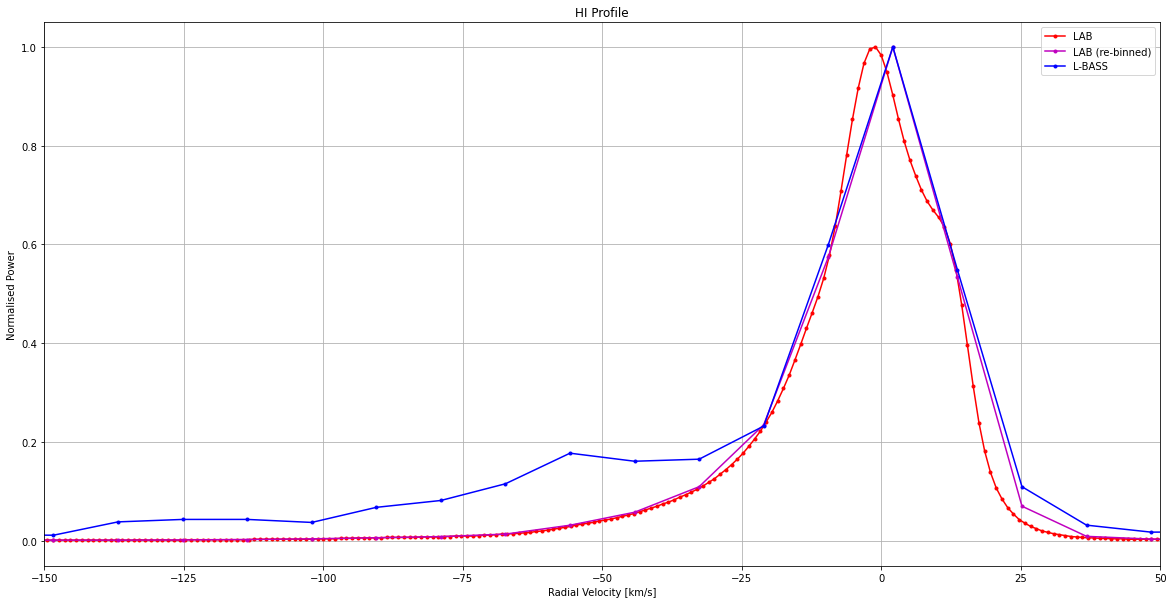

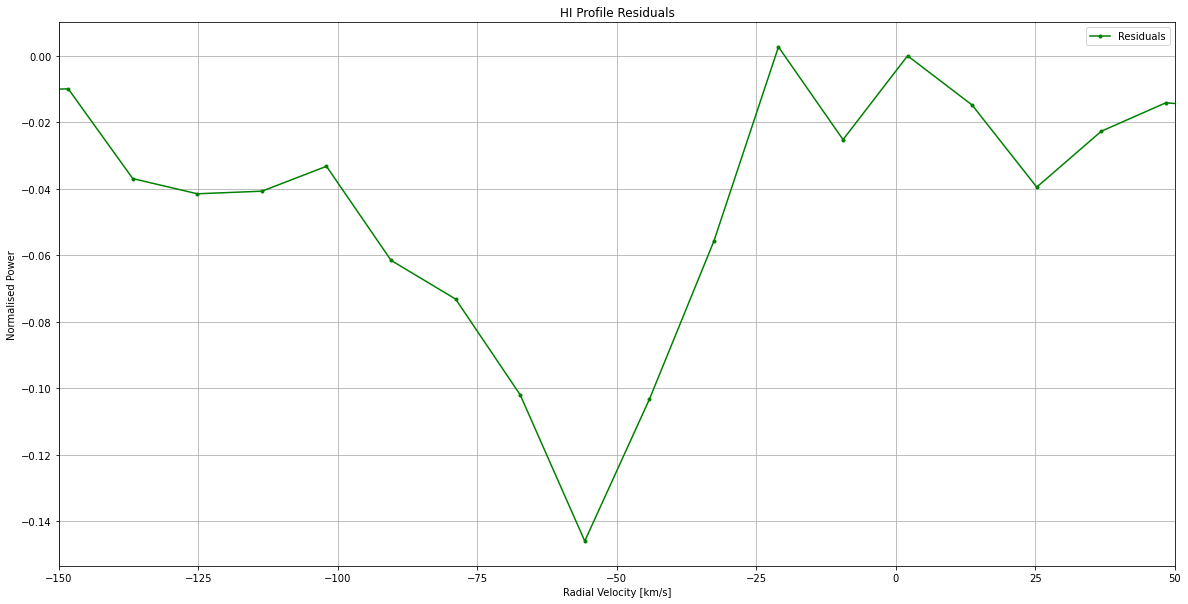

Area under LAB profile:  31.3
Area under L-BASS profile:  40.7
Difference as a % of L-BASS profile:  23.1 %


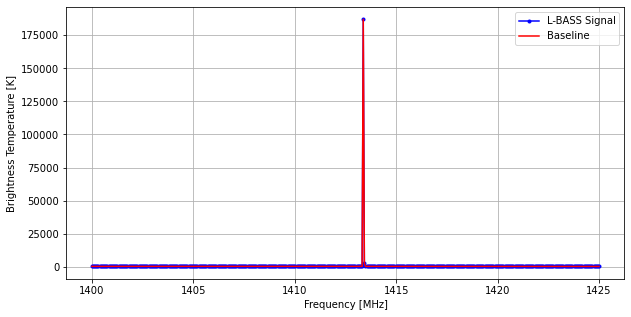

Empirical LSR correction found to be:  20.92459245924593 km / s km/s.


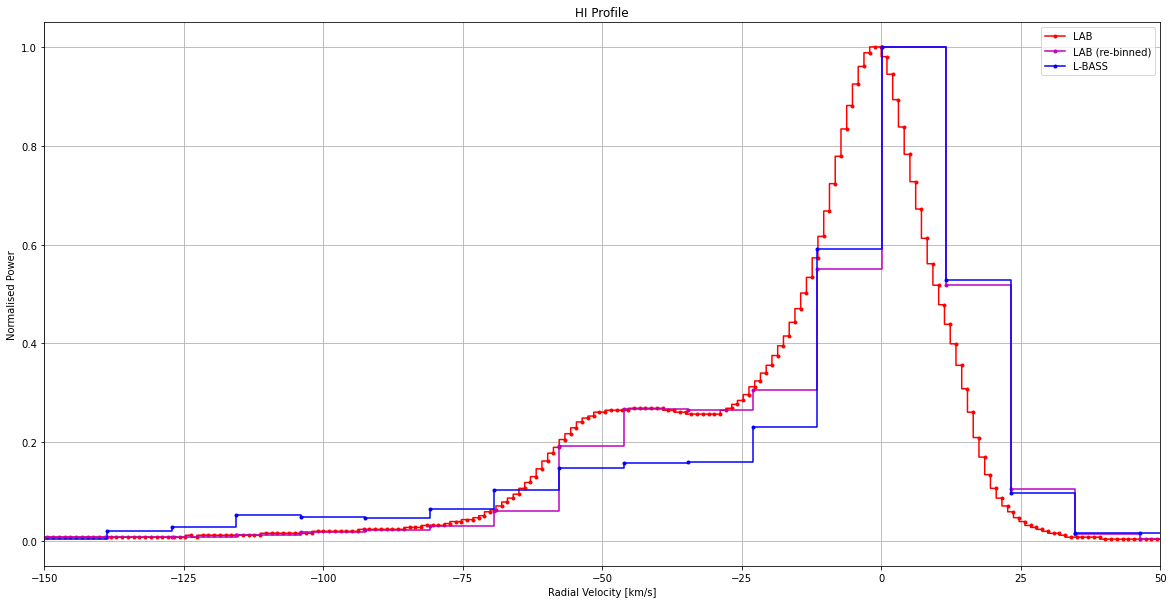

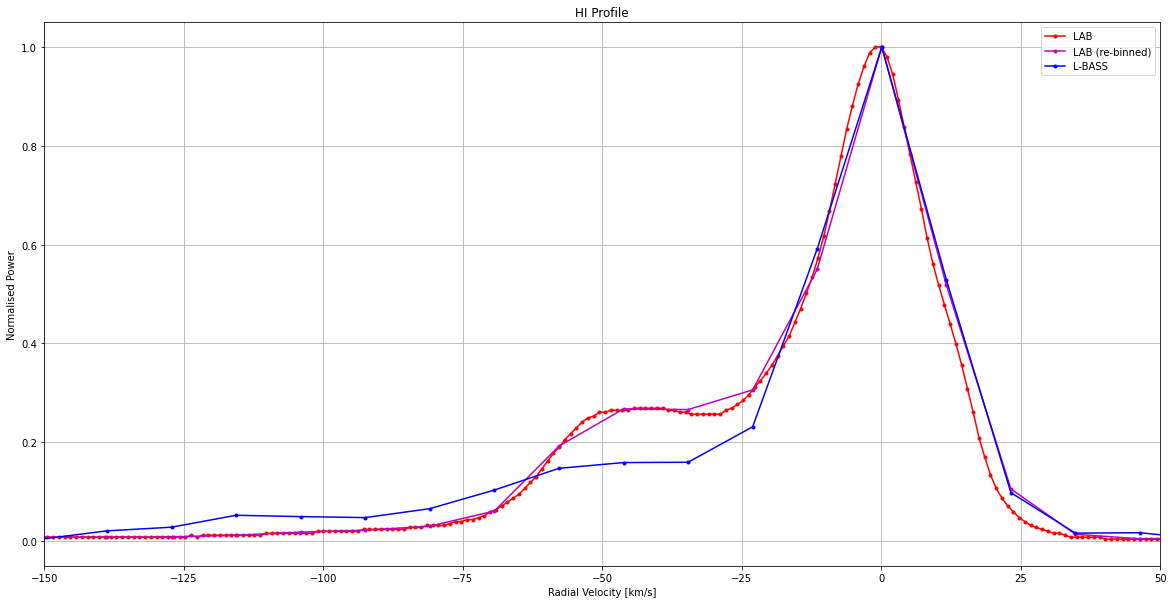

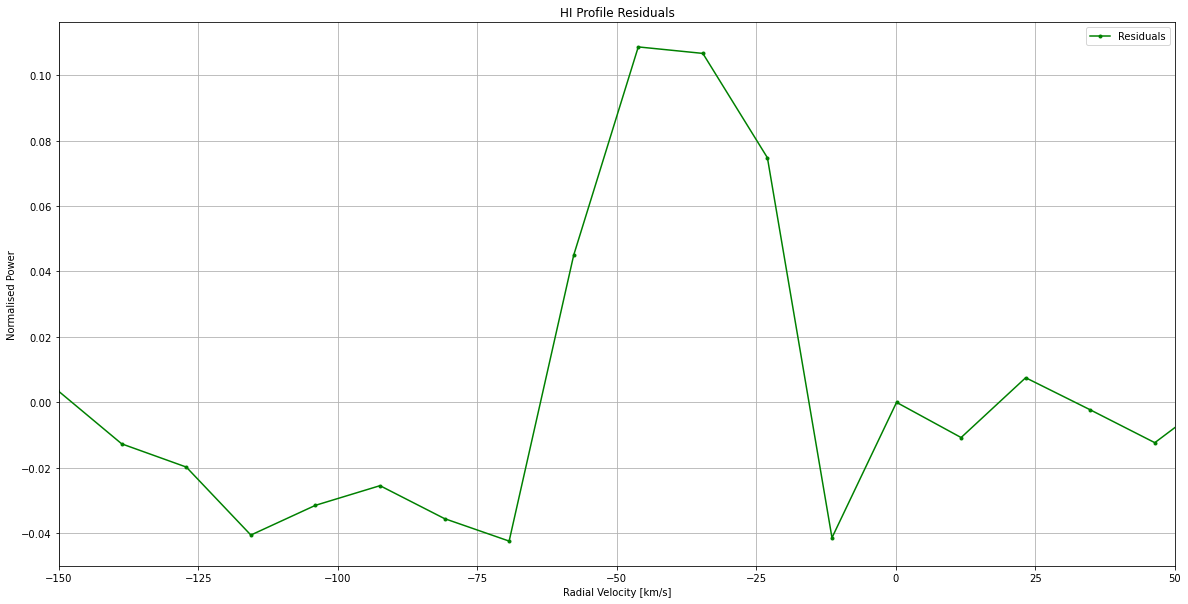

Area under LAB profile:  41.5
Area under L-BASS profile:  38.7
Difference as a % of L-BASS profile:  7.19 %


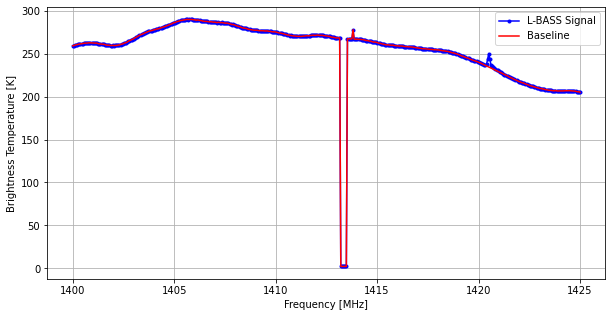

Empirical LSR correction found to be:  14.518951895189524 km / s km/s.


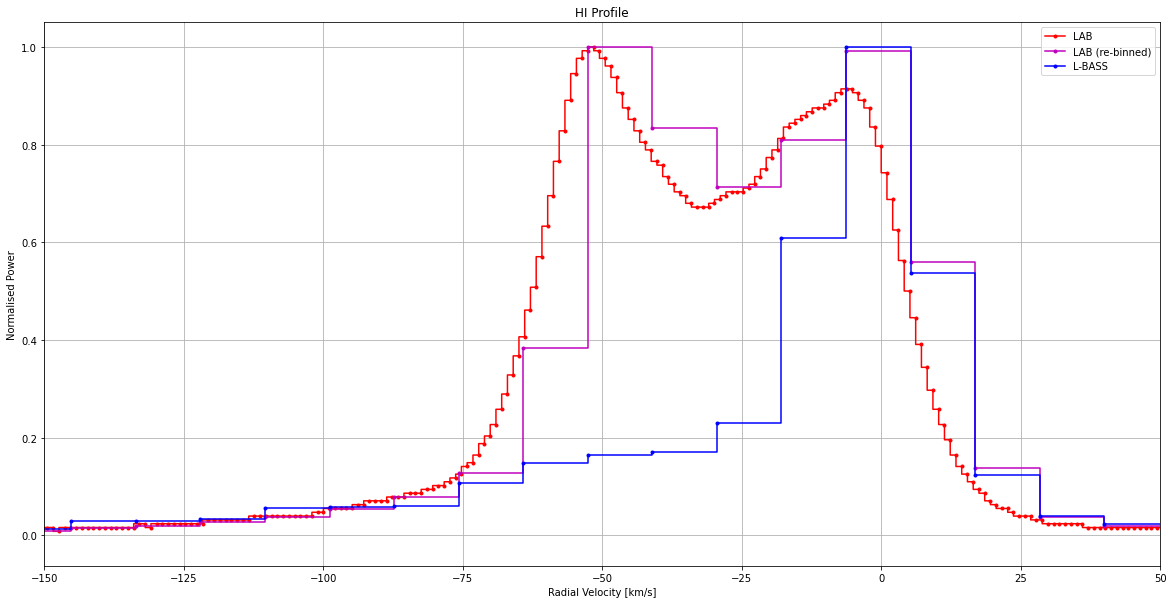

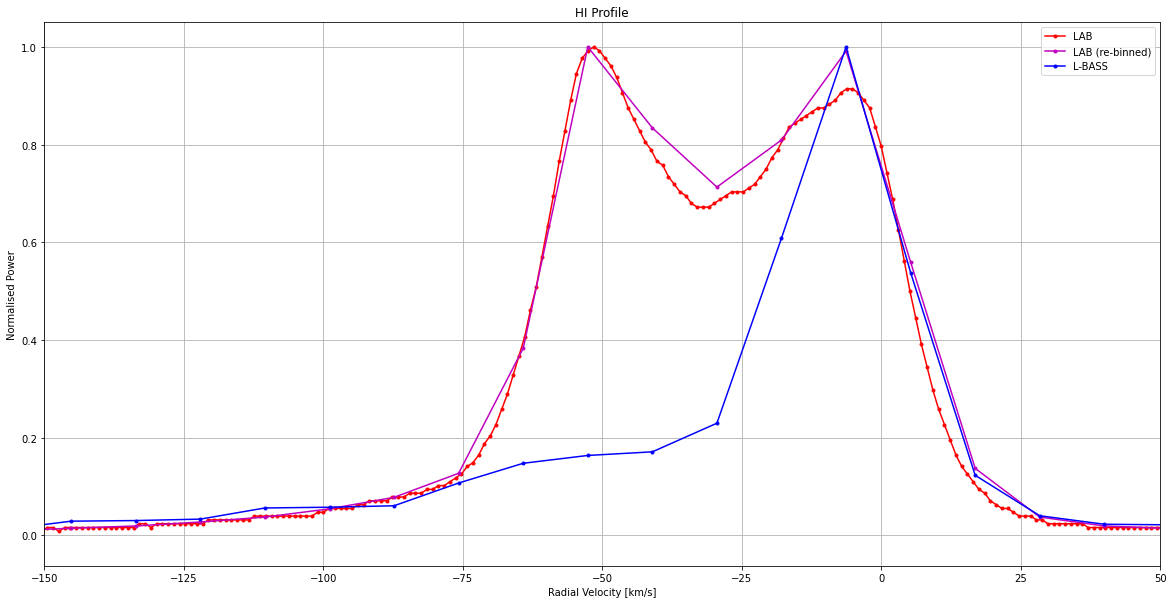

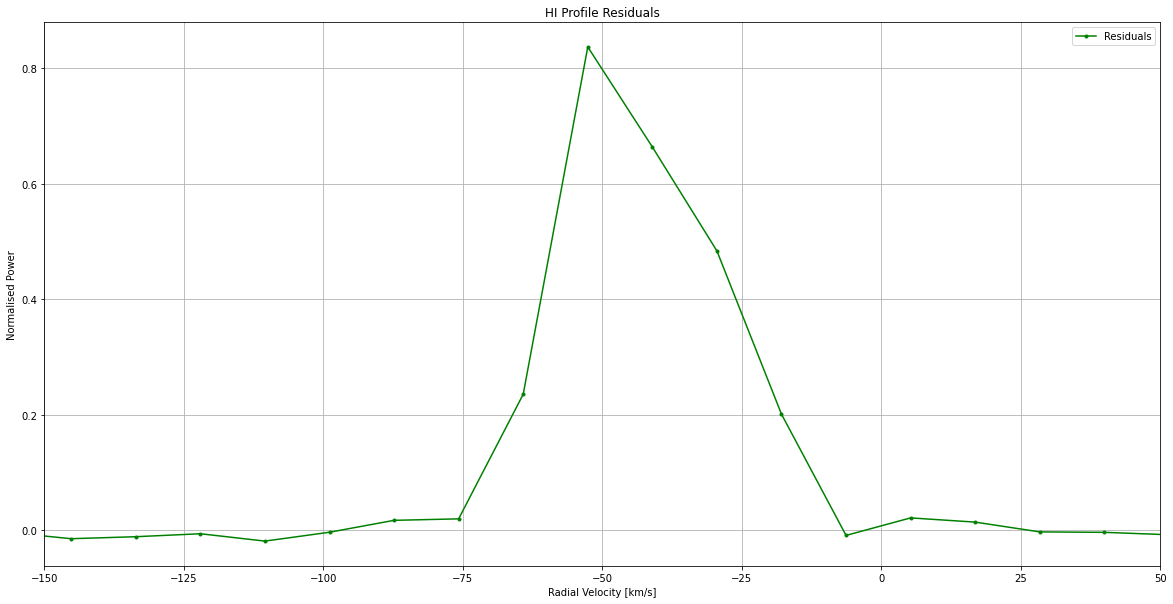

Area under LAB profile:  71.9
Area under L-BASS profile:  39.8
Difference as a % of L-BASS profile:  80.7 %


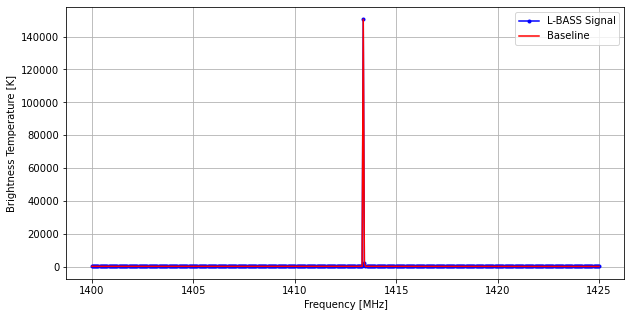

Empirical LSR correction found to be:  16.819181918191823 km / s km/s.


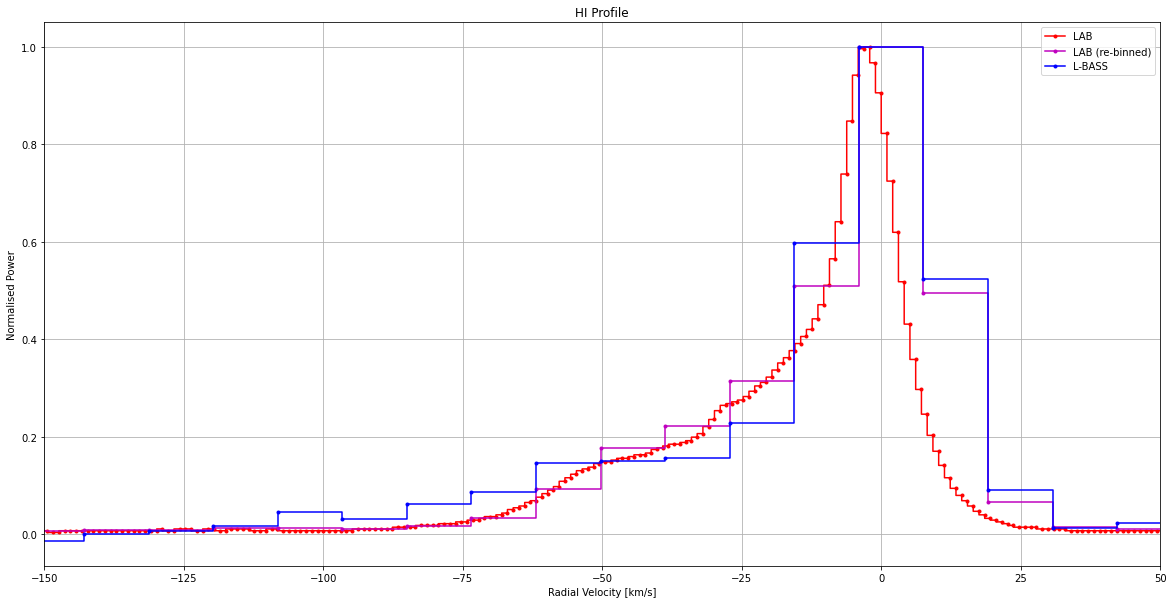

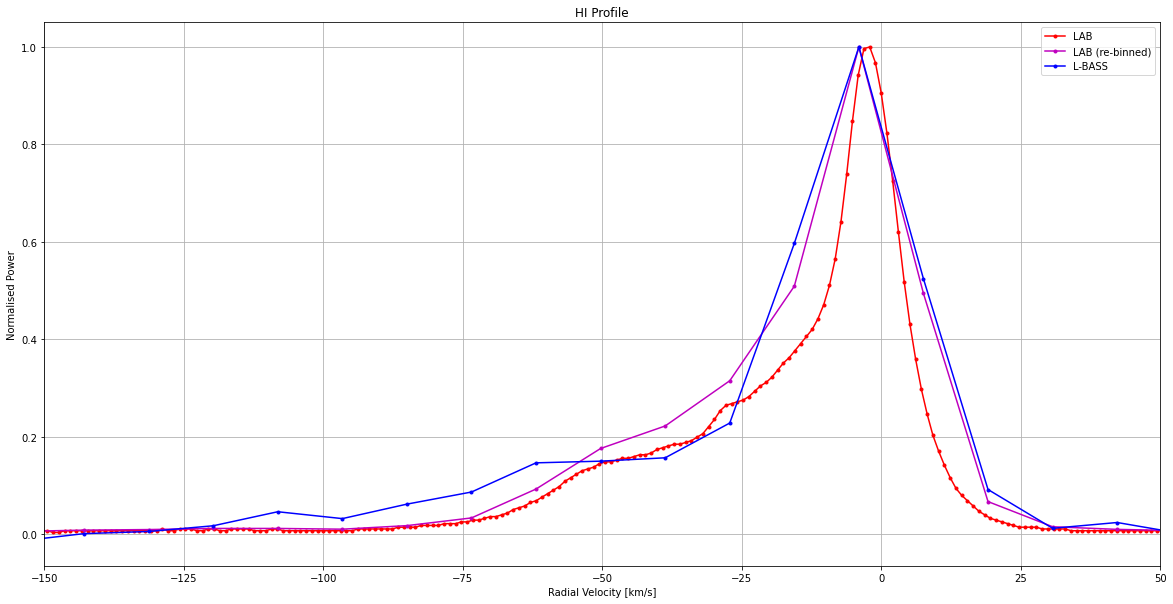

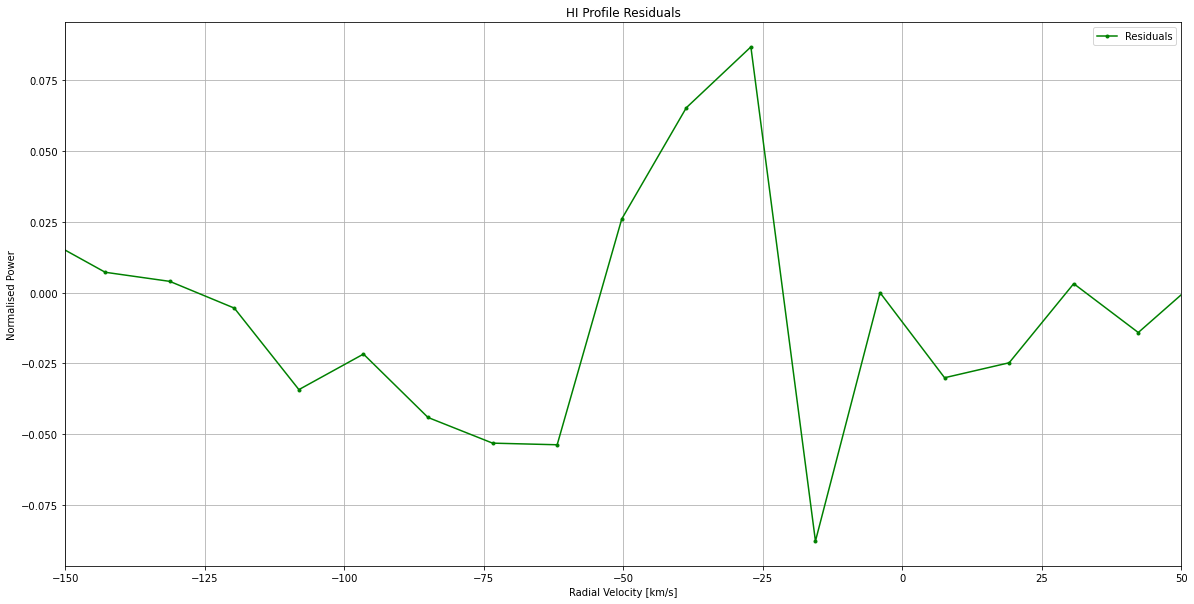

Area under LAB profile:  38.7
Area under L-BASS profile:  36.5
Difference as a % of L-BASS profile:  6.07 %


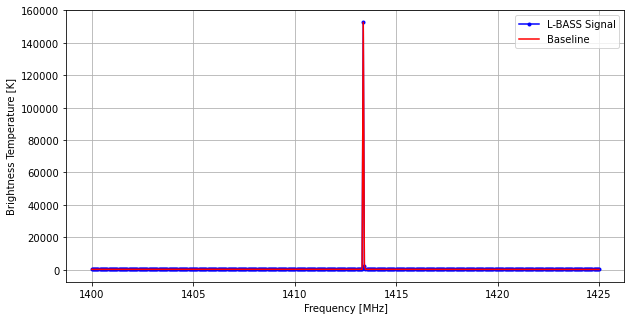

Empirical LSR correction found to be:  23.47484748474848 km / s km/s.


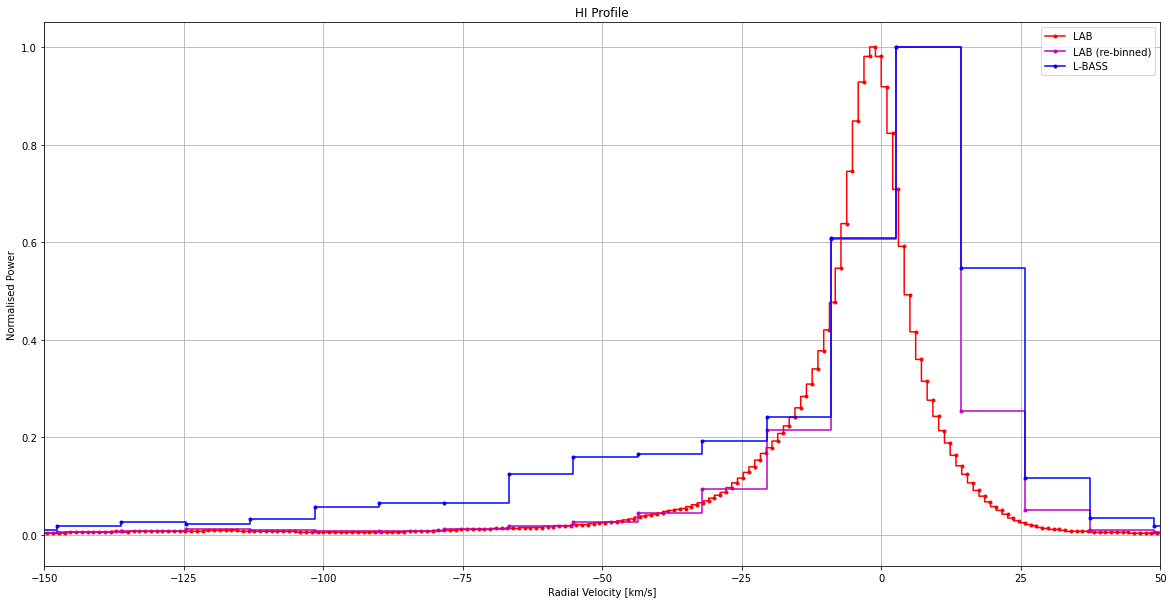

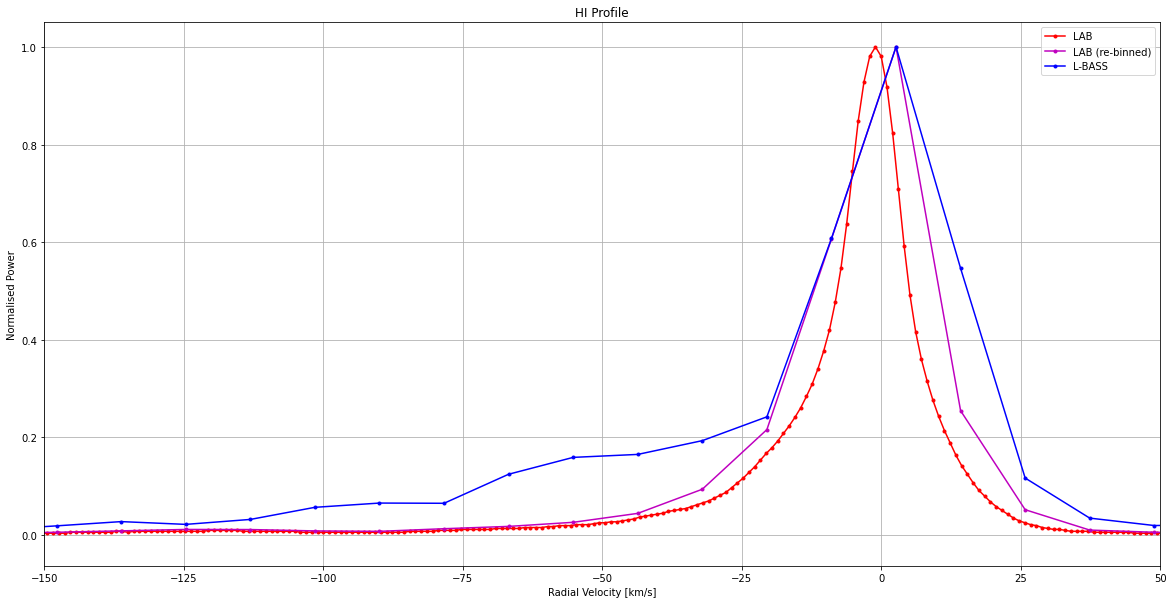

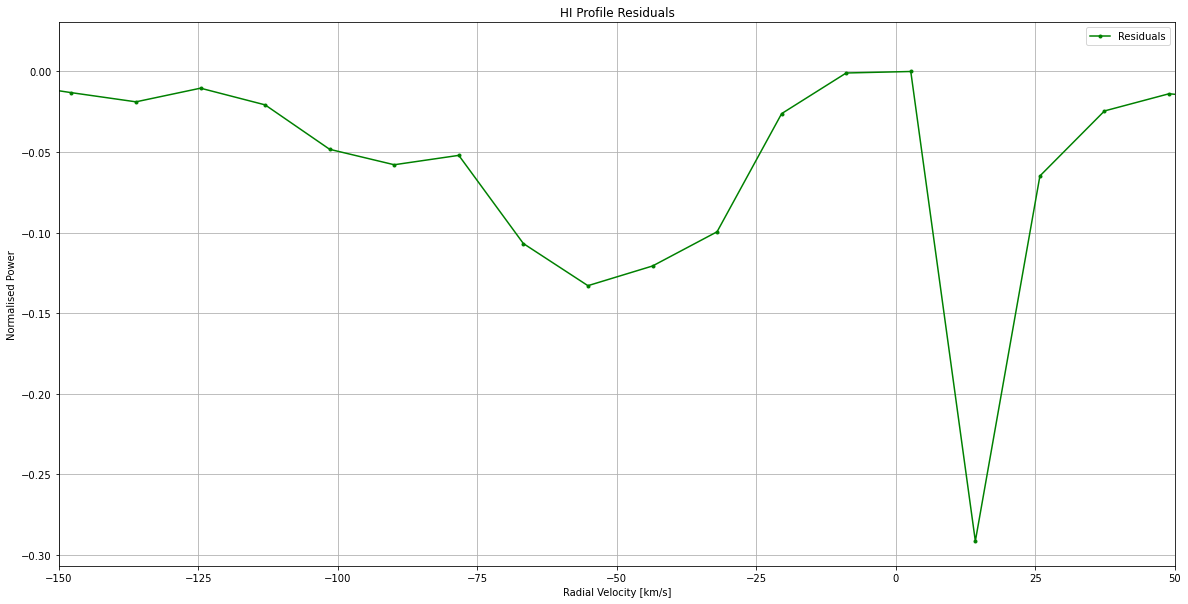

Area under LAB profile:  29.0
Area under L-BASS profile:  40.7
Difference as a % of L-BASS profile:  28.9 %


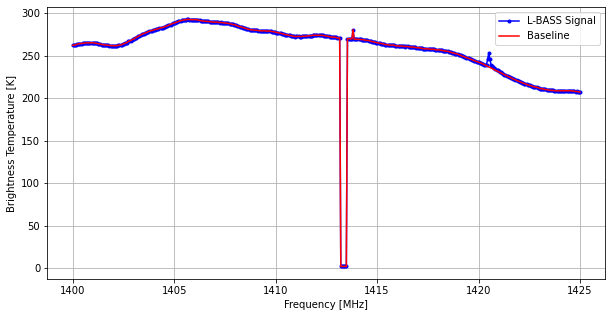

Empirical LSR correction found to be:  24.784978497849785 km / s km/s.


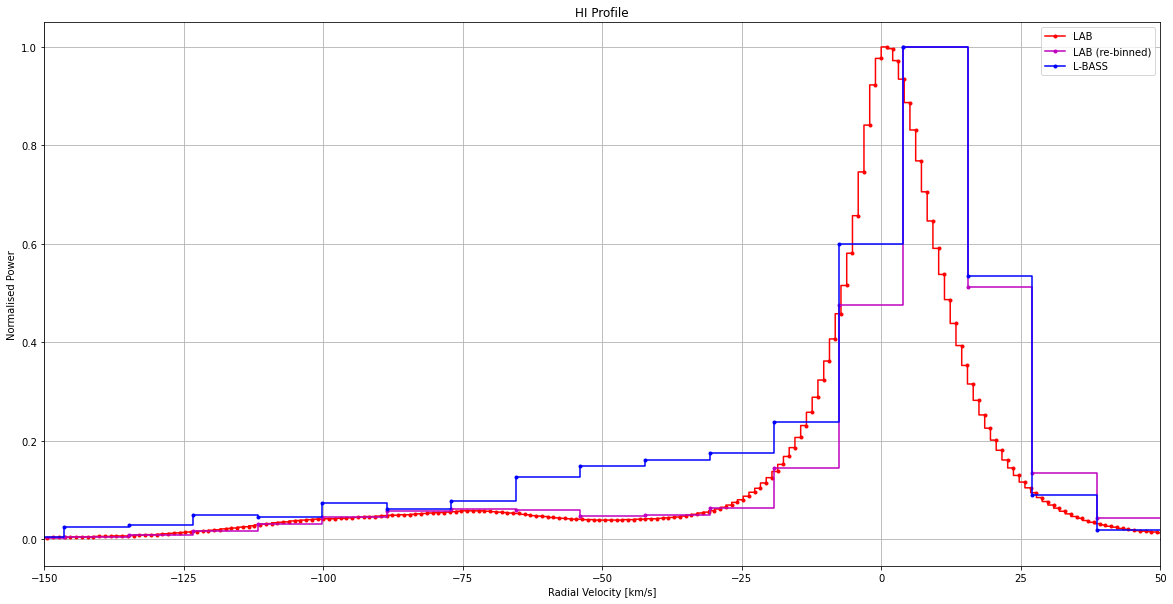

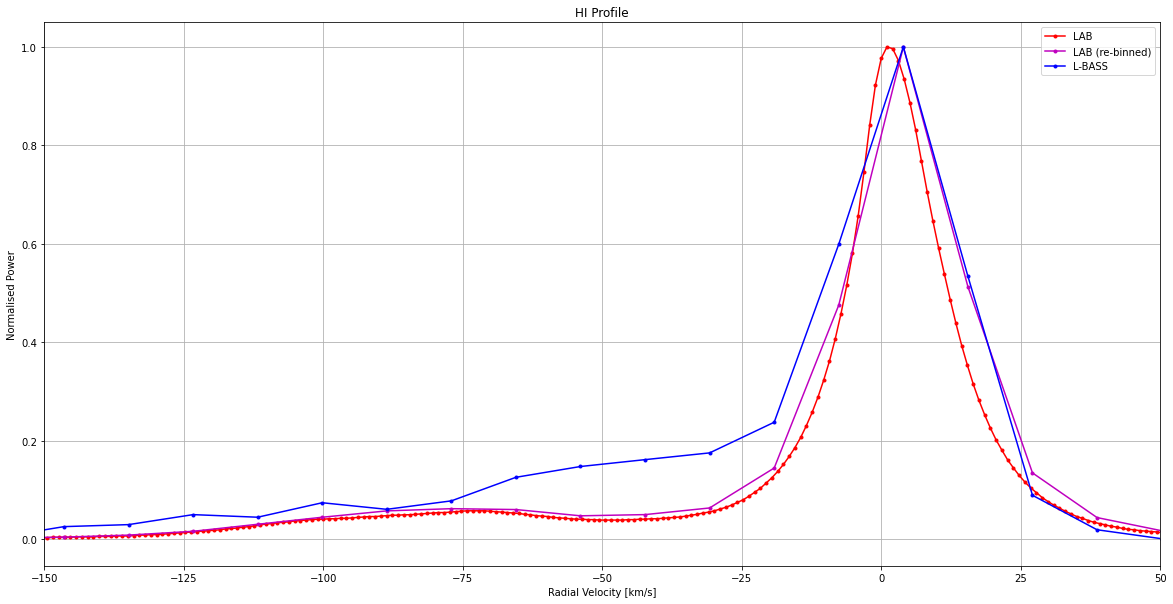

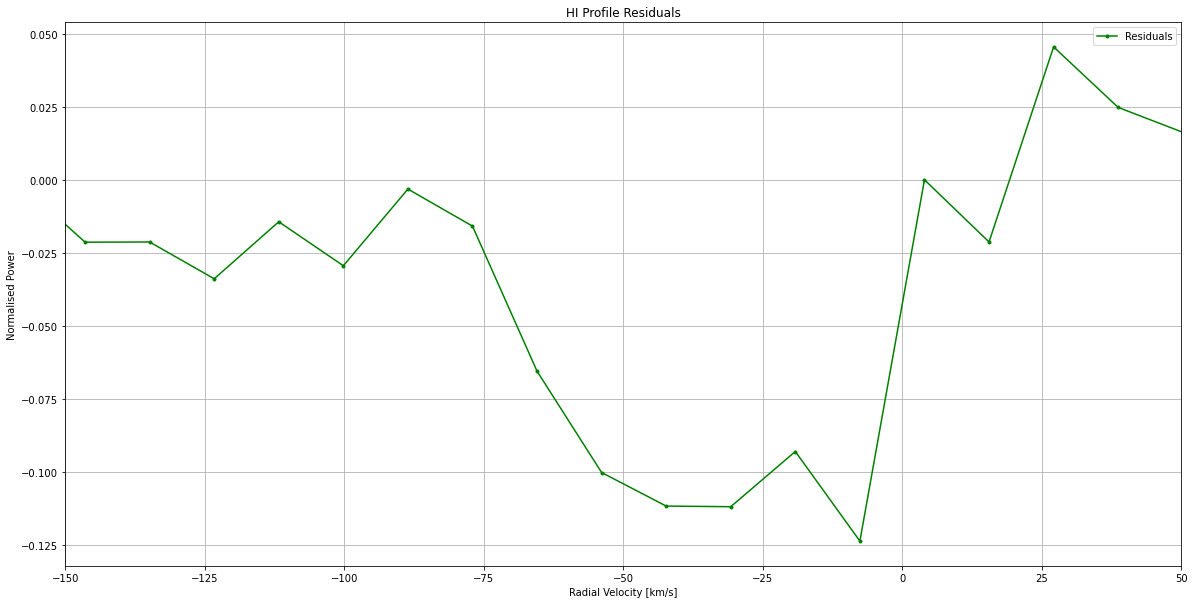

Area under LAB profile:  32.3
Area under L-BASS profile:  40.1
Difference as a % of L-BASS profile:  19.3 %


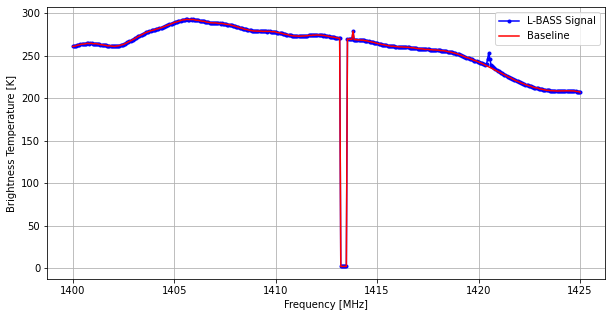

Empirical LSR correction found to be:  24.824982498249824 km / s km/s.


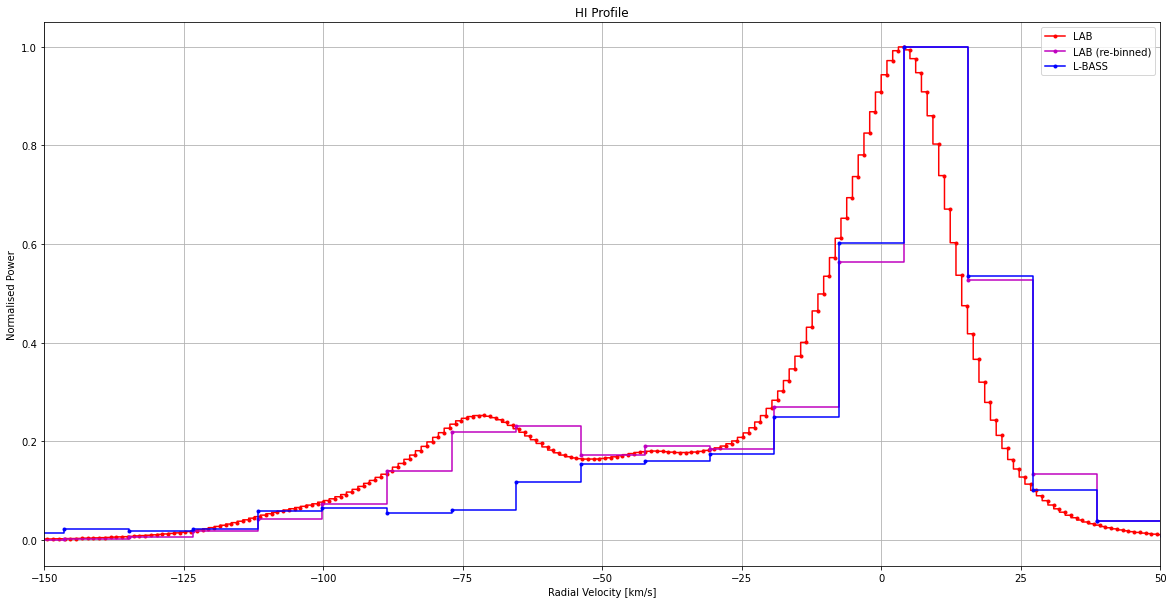

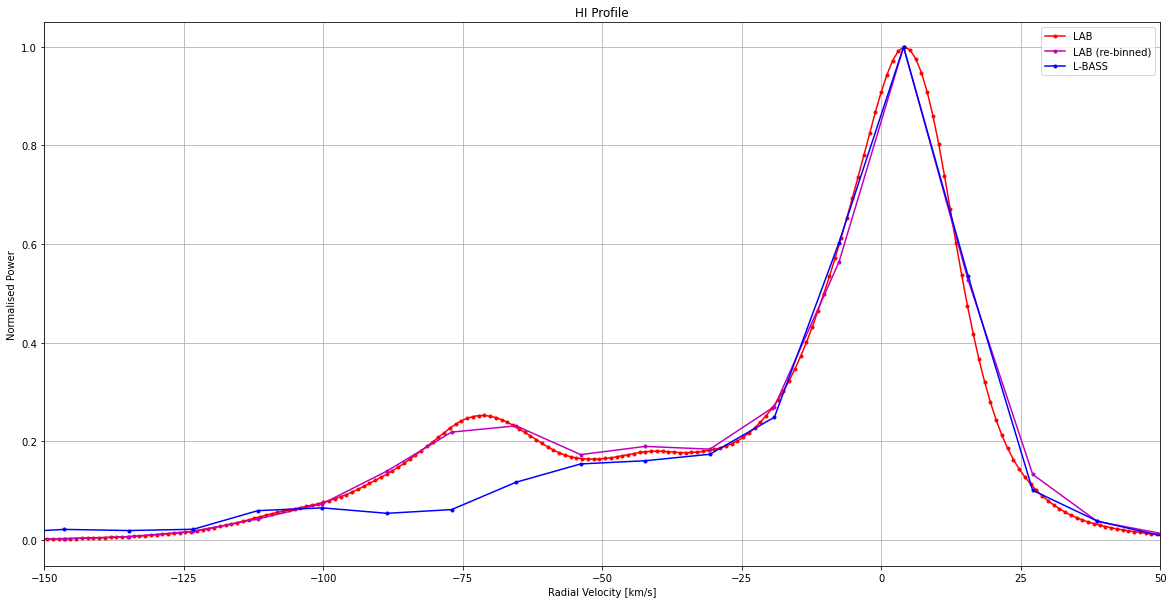

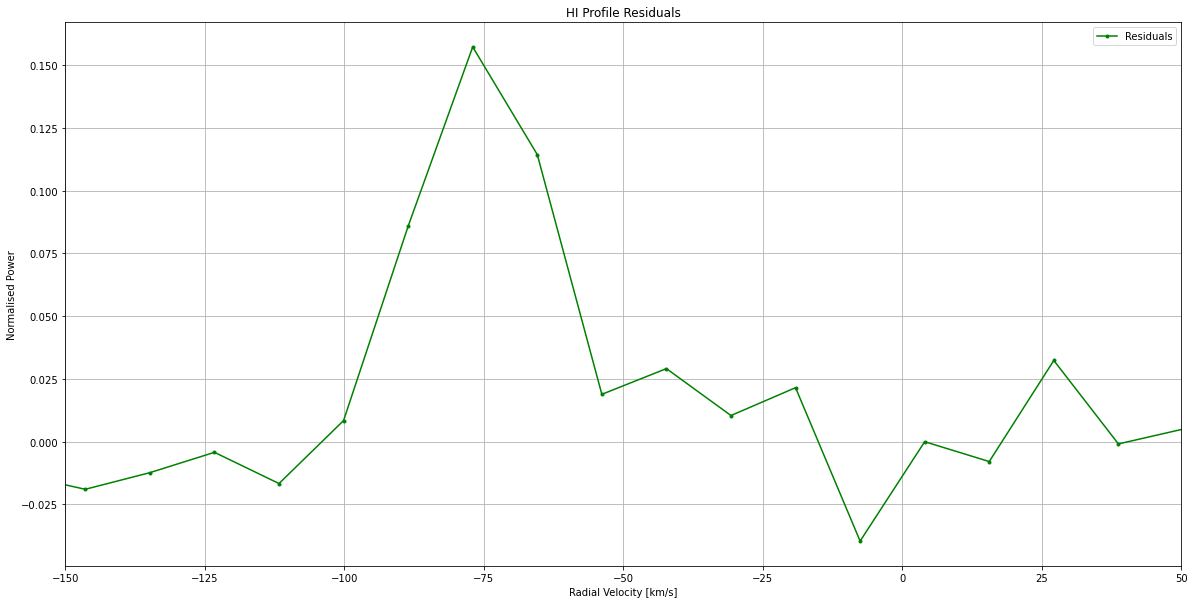

Area under LAB profile:  44.5
Area under L-BASS profile:  39.9
Difference as a % of L-BASS profile:  11.4 %


In [55]:
for i in range(0,11):
    profile_empirical_vel(transit, 1403 + 120 * i, ra[i], 480, 501)